<a href="https://colab.research.google.com/github/hiteshjck/nlp/blob/main/Vader_and_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---------------------------------------------------------------------------------------------------------**Import Libraries**------------------------------------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
from bs4 import BeautifulSoup
import re
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from google.colab import drive

---------------------------------------------------------------------------------------------------------**Data Preprocessing**------------------------------------------------------------------------------

In [ ]:
# Data preprocessing

# reading csv using pandas
drive.mount('/content/drive/')
df = pd.read_csv('drive/MyDrive/nlp_data/AmazonReview.csv')

print(df.head())
print(len(df.index))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
                                              Review  Sentiment
0  Fast shipping but this product is very cheaply...          1
1  This case takes so long to ship and it's not e...          1
2  Good for not droids. Not good for iPhones. You...          1
3  The cable was not compatible between my macboo...          1
4  The case is nice but did not have a glow light...          1
25000


In [ ]:
# text cleaning

# Handling missing values
# no missing values
df = df.dropna()

# 1. removing leading and trailing spaces
df["Review"] = df["Review"].str.strip()

# tokenization
#df["tokenized review"] = df.apply(lambda row: nltk.word_tokenize(row["Review"]), axis=1)

# Lowercasing
df["Review"] = df["Review"].str.lower()

# Map scores to sentiments (e.g., positive, neutral, negative)
df['Sentiment value'] = df['Sentiment'].apply(lambda score: 'positive' if score > 3 else ('negative' if score < 3 else 'neutral'))
print(df['Sentiment value'].value_counts())

# Removing stop words (drops accuracy @1,2,3)
# for i in stopwords.words('english'):
#    df['Review'] = df["Review"].str.replace(" "+i+" ", " ")

# 2. Removing special characters (drops accuracy @1,2,3)
# df["Review"] = df["Review"].str.replace("[\"$&+,:;=?@#|'<>.-^*()%!]", "")

print(df.head())
print(len(df.index))

negative    10000
positive     9999
neutral      5000
Name: Sentiment value, dtype: int64
                                              Review  Sentiment  \
0  fast shipping but this product is very cheaply...          1   
1  this case takes so long to ship and it's not e...          1   
2  good for not droids. not good for iphones. you...          1   
3  the cable was not compatible between my macboo...          1   
4  the case is nice but did not have a glow light...          1   

  Sentiment value  
0        negative  
1        negative  
2        negative  
3        negative  
4        negative  
24999


---------------------------------------------------------------------------------------------------- **Vader** -------------------------------------------------------------------------------------------------------

In [ ]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
# reference: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Vader prediction
analyser = SentimentIntensityAnalyzer()

df['vader prediction'] = df['Review'].apply(lambda sentence: 'positive' if (analyser.polarity_scores(sentence)['compound'] >= 0.05)
                                                                        else
                                          ('negative' if (analyser.polarity_scores(sentence)['compound'] <= -0.05) else 'neutral'))

print(df.head())

'\n# Evaluating the predictions\nprint("Accuracy:", accuracy_score([\'Sentiment value\'], predictions))\nprint("\nClassification Report:\n", classification_report(test_data[\'Sentiment value\'], predictions))\n'

In [ ]:
# Evaluating the predictions
print("Accuracy:", accuracy_score(df['Sentiment value'], df['vader prediction']))
print("\nClassification Report:\n", classification_report(df['Sentiment value'], df['vader prediction']))

Accuracy: 0.5703828153126125

Classification Report:
               precision    recall  f1-score   support

    negative       0.73      0.49      0.58     10000
     neutral       0.21      0.08      0.12      5000
    positive       0.55      0.90      0.68      9999

    accuracy                           0.57     24999
   macro avg       0.49      0.49      0.46     24999
weighted avg       0.55      0.57      0.53     24999



---------------------------------------------------------------------------------------------------- **BERT** -------------------------------------------------------------------------------------------------------

In [ ]:
"""This dataset cannot be used

# Data preprocessing

# reading csv using pandas
drive.mount('/content/drive/')
df = pd.read_csv('drive/MyDrive/nlp_data/Loughran-McDonald_MasterDictionary_1993-2021.csv')

print(df.head())
print(len(df.index))
print(df['Negative'].value_counts())"""

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
        Word  Seq_num  Word Count  Word Proportion  Average Proportion  \
0   AARDVARK        1         354     1.550080e-08        1.422600e-08   
1  AARDVARKS        2           3     1.313627e-10        8.653817e-12   
2      ABACI        3           9     3.940882e-10        1.169679e-10   
3      ABACK        4          29     1.269840e-09        6.654735e-10   
4     ABACUS        5        8570     3.752595e-07        3.809464e-07   

        Std Dev  Doc Count  Negative  Positive  Uncertainty  Litigious  \
0  3.815486e-06         99         0         0            0          0   
1  9.241714e-09          1         0         0            0          0   
2  5.290465e-08          7         0         0            0          0   
3  1.595100e-07         28         0         0            0          0   
4  3.529356e-05       1108         0         0        

In [ ]:
drop_indices = np.random.choice(df.index, 24500, replace=False)
df = df.drop(drop_indices)
print(df['Sentiment value'].value_counts())
print(len(df.index))

positive    195
negative    193
neutral     111
Name: Sentiment value, dtype: int64
499


In [ ]:
# reference: https://www.geeksforgeeks.org/sentiment-classification-using-bert/

from transformers import BertTokenizer, TFBertForSequenceClassification

# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

# Train dataset
train_data['Cleaned_sentence'] = train_data['Review'].apply(text_cleaning).tolist()
# Test dataset
test_data['Cleaned_sentence'] = test_data['Review'].apply(text_cleaning)

#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# creating a binary column for sentiment
train_data['Sentiment binary'] = df['Sentiment'].apply(lambda score: 1 if score >= 3 else 0)
test_data['Sentiment binary'] = df['Sentiment'].apply(lambda score: 1 if score >= 3 else 0)

# Training data
Reviews = train_data['Cleaned_sentence']
Target = train_data['Sentiment binary']

# Test data
test_reviews = test_data['Cleaned_sentence']
test_targets = test_data['Sentiment binary']

# Split TEST data into test and validation
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                    test_targets,
                                                    test_size=0.5,
                                                    stratify = test_targets)

max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_len,
                                              return_tensors='tf')

# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

<ipython-input-5-f0a462028d6b>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-5-f0a462028d6b>:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Train the model
# attempt 1: batch = 16, epoch = 2, accuracy = 62% (amazon review dataset)

history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=(
      [X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
    batch_size=32,
    epochs=5
)

#Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

Epoch 1/2
25/25 [==============================] - 507s 18s/step - loss: 0.6692 - accuracy: 0.6040 - val_loss: 0.6839 - val_accuracy: 0.5800
Epoch 2/2
2/2 [==============================] - 15s 5s/step - loss: 0.6519 - accuracy: 0.6200
Test loss: 0.6518710851669312, Test accuracy: 0.6200000047683716


In [ ]:
#Save the model and tokenizer to the local folder
path = 'drive/MyDrive/nlp_data'

# Save tokenizer
tokenizer.save_pretrained(path +'/Tokenizer')

# Save model
model.save_pretrained(path +'/Model')

In [ ]:
# testing the saved model

from transformers import BertTokenizer, TFBertForSequenceClassification

path = 'drive/MyDrive/nlp_data'
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model')

pred = bert_model.predict(
    [X_test_encoded['input_ids'], X_test_encoded['token_type_ids'], X_test_encoded['attention_mask']])

# pred is of type TFSequenceClassifierOutput
logits = pred.logits

# Use argmax along the appropriate axis to get the predicted labels
pred_labels = tf.argmax(logits, axis=1)

# Convert the predicted labels to a NumPy array
pred_labels = pred_labels.numpy()

label = {
    1: 'positive',
    0: 'Negative'
}

# Map the predicted labels to their corresponding strings using the label dictionary
pred_labels = [label[i] for i in pred_labels]
Actual = [label[i] for i in y_test]

print("Classification Report: \n", classification_report(Actual, pred_labels))
print("\nAccuracy: ", accuracy_score(Actual, pred_labels))

In [ ]:
# checking the trained model on live data

from transformers import BertTokenizer, TFBertForSequenceClassification

path = 'drive/MyDrive/nlp_data'
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer1')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model1')

def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    label = {
    2: 'Positive',
    1: 'Neutral',
    0: 'Negative'
    }

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]
    return pred_labels

Review ='@Tejas Pandya , Thanks SirZaroor party hogi, aap jaha bologe waha aake karenge party 🎉This was really required, was really demotivated with no allotment in ~8 bHNI applications in IKIO, Idea, Senco.Aapke kitne lage isme ?@Bull market , IDFC Bank.@SUPERPP Thanks Brother, hoping you also got allotted.@YNIMI , 8 bHNI applications.'
Get_sentiment(Review)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at drive/MyDrive/nlp_data/Model1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 7s 7s/step


['Neutral']

------------------------------------------------------------------------------------------- **Google translate api** -------------------------------------------------------------------------------------------------------

In [ ]:
pip install -U deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.0 MB/s eta 0:00:00


In [ ]:
from deep_translator import GoogleTranslator

translated = GoogleTranslator(source='auto', target='en').translate("Apna gala khud dabana aur Adlabs IPO subscribe karna! Same Same!then subscribe. Apna gala khud dabana")
print(translated)

Press your gala yourself and subscribe to Adlabs IPO! Same Same!then subscribe. pressing my throat myself


--------------------------------------------------------------------------------- **Vader and google trans experiment** ------------------------------------------------------------------------------------------

In [ ]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.3 MB/s eta 0:00:00


In [ ]:
pip install -U deep-translator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 766.1 kB/s eta 0:00:00


In [ ]:
# Data preprocessing

# reading csv using pandas
drive.mount('/content/drive/')

xls = pd.ExcelFile('drive/MyDrive/nlp_data/radiant-cash-management-ipo.xlsx')
my_df = pd.read_excel(xls, 'Message Board')

print(my_df.head())
print(len(my_df.index))

Mounted at /content/drive/
                 MsgNo.                     Date  Name  \
0  127. Gaurav DD dimer  Jan 28, 2023 1:29:10 PM   NaN   
1        126. Takamichi  Jan 5, 2023 10:48:35 AM   NaN   
2    126.1. Multibagger  Jan 5, 2023 12:30:47 PM   NaN   
3          126.2. PKRAJ   Jan 5, 2023 4:34:10 PM   NaN   
4          125. Eagleye   Jan 4, 2023 5:01:34 PM   NaN   

                                             Message  
0  Results Today, with Dividend consideration in ...  
1  Just wanted to say 2 things1. Inputs are not r...  
2  Focus on increasing comment quality and not on...  
3  @TakamichiYou are absolutely right. There are ...  
4  THE MOST RELIABLEList of Mainboard IPOs IN THE...  
290


In [ ]:
# text cleaning

# dropping columns
my_df = my_df.drop(['MsgNo.', 'Date', 'Name'], axis=1)

# Handling missing values
my_df = my_df.dropna()

# text cleaning
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

my_df['cleaned message'] = my_df['Message'].apply(text_cleaning)

print(my_df.head())
print(len(my_df.index))

"""
drop_indices = np.random.choice(my_df.index, 285, replace=False)
my_df = my_df.drop(drop_indices)
print(my_df.head())
print(len(my_df.index))
"""

                                             Message  \
0  Results Today, with Dividend consideration in ...   
1  Just wanted to say 2 things1. Inputs are not r...   
2  Focus on increasing comment quality and not on...   
3  @TakamichiYou are absolutely right. There are ...   
4  THE MOST RELIABLEList of Mainboard IPOs IN THE...   

                                     cleaned message  
0  Results Today, with Dividend consideration in ...  
1  Just wanted to say 2 things1 Inputs are not re...  
2  Focus on increasing comment quality and not on...  
3  TakamichiYou are absolutely right There are ma...  
4  THE MOST RELIABLEList of Mainboard IPOs IN THE...  
290


<ipython-input-4-e30ba331cd7b>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


'\ndrop_indices = np.random.choice(my_df.index, 285, replace=False)\nmy_df = my_df.drop(drop_indices)\nprint(my_df.head())\nprint(len(my_df.index))\n'

In [ ]:
count = 0
for i in my_df['cleaned message']:
  if count>5: break
  print(i, "\n")
  #count += 1

In [ ]:
# reference: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator

# Vader prediction
analyser = SentimentIntensityAnalyzer()

def gtrans_func(sentence):
  return GoogleTranslator(source='auto', target='en').translate(sentence)

#my_df['vader prediction'] = my_df['Message'].apply(lambda sentence: 'positive' if (analyser.polarity_scores(sentence)['compound'] >= 0.05)
#                                                                        else
#                                          ('negative' if (analyser.polarity_scores(sentence)['compound'] <= -0.05) else 'neutral'))

my_df['vader values'] = my_df['cleaned message'].apply(lambda sentence: analyser.polarity_scores(sentence))
my_df['positive score'] = my_df['vader values'].apply(lambda val_dict: val_dict['pos'])
my_df['negative score'] = my_df['vader values'].apply(lambda val_dict: val_dict['neg'])
my_df['neutral score'] = my_df['vader values'].apply(lambda val_dict: val_dict['neu'])
my_df['compound score'] = my_df['vader values'].apply(lambda val_dict: val_dict['compound'])

print(my_df.head())
print(len(my_df.index))

                                             Message  \
0  Results Today, with Dividend consideration in ...   
1  Just wanted to say 2 things1. Inputs are not r...   
2  Focus on increasing comment quality and not on...   
3  @TakamichiYou are absolutely right. There are ...   
4  THE MOST RELIABLEList of Mainboard IPOs IN THE...   

                                     cleaned message  \
0  Results Today, with Dividend consideration in ...   
1  Just wanted to say 2 things1 Inputs are not re...   
2  Focus on increasing comment quality and not on...   
3  TakamichiYou are absolutely right There are ma...   
4  THE MOST RELIABLEList of Mainboard IPOs IN THE...   

                                        vader values  positive score  \
0  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...           0.000   
1  {'neg': 0.037, 'neu': 0.87, 'pos': 0.094, 'com...           0.094   
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...           0.000   
3  {'neg': 0.045, 'neu': 0.9, 'pos': 0

In [ ]:
print("average positive:", my_df['positive score'].sum()/len(my_df.index))
print("average negative:", my_df['negative score'].sum()/len(my_df.index))
print("average neutral:", my_df['neutral score'].sum()/len(my_df.index))
print("average compound:", my_df['compound score'].sum()/len(my_df.index))

average positive: 0.1348689655172414
average negative: 0.04285517241379311
average neutral: 0.8222758620689655
average compound: 0.23206931034482758


--------------------------------------------------------------------------------- **Regression** ------------------------------------------------------------------------------------------

In [ ]:
# Data preprocessing

# reading excel using pandas
drive.mount('/content/drive/')
xls = pd.ExcelFile('drive/MyDrive/nlp_data/Co,base,listing,subs.xlsx')
val_df = pd.read_excel(xls, 'Sheet1')

# droping null rows
val_df = val_df.dropna()

# deriving listing difference and percentage
val_df = val_df.assign(listing_difference = lambda x: (x['Open Price.NSE'] - x['Final Issue Price']))
val_df = val_df.assign(listing_percentage = lambda x: (x['listing_difference']/x['Final Issue Price']))

print(val_df.head())
print(len(val_df.index))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
                     Source.Name  BSE Symbol  NSE Symbol  \
0  adlabs_entertainment_ipo.xlsx    539056.0    IMAGICAA   
1    alkem_laboratories_ipo.xlsx    539523.0       ALKEM   
2       cafe_coffee_day_ipo.xlsx    539436.0   COFFEEDAY   
3       dr_lal_pathlabs_ipo.xlsx    539524.0  LALPATHLAB   
4                indigo_ipo.xlsx    539448.0      INDIGO   

                   NAME  Final Issue Price  Open Price.BSE  Open Price.NSE  \
0  Adlabs_Entertainment              180.0          167.95           162.2   
1    Alkem_Laboratories             1050.0         1380.00          1380.0   
2       Cafe_Coffee_Day              328.0          313.00           317.0   
3       Dr_Lal_Pathlabs              550.0          717.00           720.0   
4                Indigo              765.0          856.00           855.8   

   Close Price.BSE  Close Price.NSE  Su

<ipython-input-6-bf60d54bac09>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(val_df.corr(), cmap="YlGnBu", annot=True)


<Axes: >

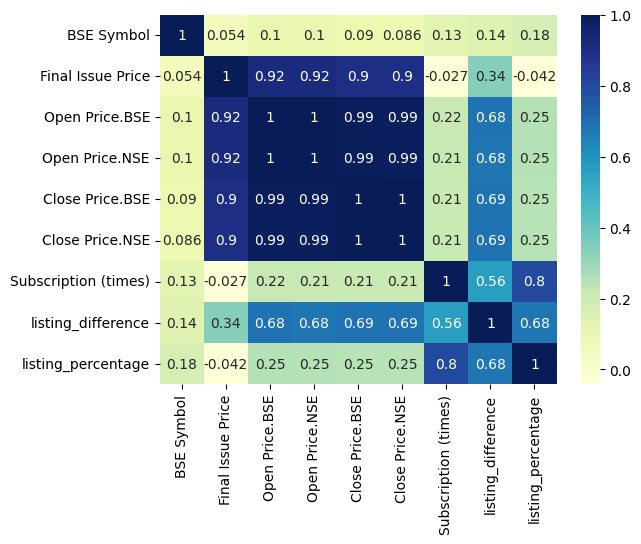

In [ ]:
sb.heatmap(val_df.corr(), cmap="YlGnBu", annot=True)

Text(0, 0.5, 'listing_percentage')

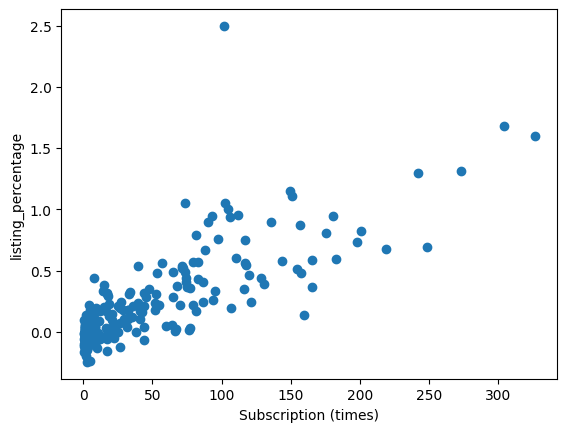

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(val_df['Subscription (times)'], val_df['listing_percentage'])
plt.xlabel('Subscription (times)')
plt.ylabel('listing_percentage')

In [ ]:
from sklearn import linear_model

X = np.array(val_df['Subscription (times)']).reshape(-1, 1)
y = np.array(val_df['listing_percentage']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# variance score: 1 means perfect prediction
print('Number of test samples:', len(y_test))
print('\nVariance score on test data:', regr.score(X_test, y_test))
print('Variance score on train data:', regr.score(X_train, y_train))

# evaluation of the regression
data = regr.predict(X_test)
# Mean Squared Error: 0 means the model is perfect.
print('\nMean Squared Error', mean_squared_error(y_test, data))
# The lower the RMSE, the better the model and its predictions
print('Root mean Squared Error', mean_squared_error(y_test, data, squared=False))
# The lower the MAE, the better the model and its predictions
print('Mean abs Error', mean_absolute_error(y_test, data))

Number of test samples: 78

Variance score on test data: 0.6235240315963405
Variance score on train data: 0.6503010503319533

Mean Squared Error 0.0323344169709371
Root mean Squared Error 0.179817732637627
Mean abs Error 0.12922470696979296


Text(0, 0.5, 'listing_percentage')

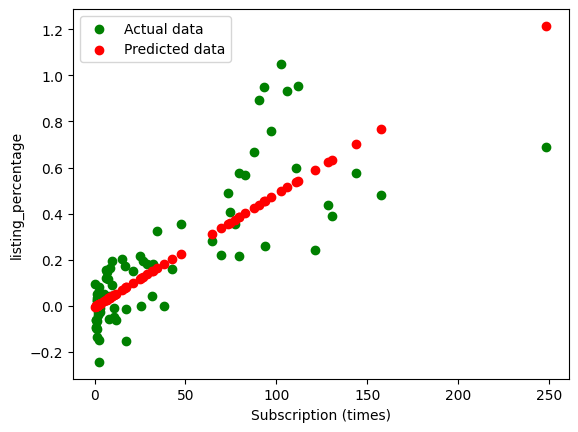

In [ ]:
plt.scatter(X_test, y_test, color="green", label='Actual data')
plt.scatter(X_test, data, color="red", label='Predicted data')
plt.legend()
plt.xlabel('Subscription (times)')
plt.ylabel('listing_percentage')

--------------------------------------------------------------------------------- **Vader scores for comments** ------------------------------------------------------------------------------------------

In [ ]:
# Data preprocessing

# reading csv using pandas
drive.mount('/content/drive/')
xls = pd.ExcelFile('drive/MyDrive/nlp_data/Message Board 2015-2023.xlsx')
my_df = pd.read_excel(xls, 'Data from chittorgarh website')

print(my_df.head())
print(len(my_df.index))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
                     Source.Name                MsgNo.                Date  \
0  adlabs_entertainment_ipo.xlsx      84. RAJESH SINGH 2015-05-21 16:56:04   
1  adlabs_entertainment_ipo.xlsx  83. VINOD JAIN NICKY 2015-05-18 16:01:11   
2  adlabs_entertainment_ipo.xlsx         82. Vraj Shah 2015-04-06 19:19:42   
3  adlabs_entertainment_ipo.xlsx            81. PavanM 2015-04-06 10:47:16   
4  adlabs_entertainment_ipo.xlsx          81.1. sushil 2015-04-06 11:47:11   

                                  Message  
0             My choice is Adlabs.Regards  
1                     ANY OTHER NEW ISSUE  
2                      Rex issue declared  
3  Excellent recovery...now at 199..enjoy  
4                 price 180.00 at 1145 am  
335985


In [ ]:
# text cleaning

# dropping columns
# my_df = my_df.drop(['MsgNo.', 'Date'], axis=1)

# Handling missing values
my_df = my_df.dropna()

# text cleaning
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

my_df['cleaned message'] = my_df['Message'].apply(text_cleaning)

print(my_df.head())
print(len(my_df.index))

<ipython-input-21-9d17cc8c1f3f>:11: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")
<ipython-input-21-9d17cc8c1f3f>:11: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


                     Source.Name                MsgNo.                Date  \
0  adlabs_entertainment_ipo.xlsx      84. RAJESH SINGH 2015-05-21 16:56:04   
1  adlabs_entertainment_ipo.xlsx  83. VINOD JAIN NICKY 2015-05-18 16:01:11   
2  adlabs_entertainment_ipo.xlsx         82. Vraj Shah 2015-04-06 19:19:42   
3  adlabs_entertainment_ipo.xlsx            81. PavanM 2015-04-06 10:47:16   
4  adlabs_entertainment_ipo.xlsx          81.1. sushil 2015-04-06 11:47:11   

                                  Message                    cleaned message  
0             My choice is Adlabs.Regards         My choice is AdlabsRegards  
1                     ANY OTHER NEW ISSUE                ANY OTHER NEW ISSUE  
2                      Rex issue declared                 Rex issue declared  
3  Excellent recovery...now at 199..enjoy  Excellent recoverynow at 199enjoy  
4                 price 180.00 at 1145 am             price 18000 at 1145 am  
335832


In [ ]:
pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
# reference: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Vader prediction
analyser = SentimentIntensityAnalyzer()

my_df['vader values'] = my_df['cleaned message'].apply(lambda sentence: analyser.polarity_scores(sentence))
my_df['positive score'] = my_df['vader values'].apply(lambda val_dict: val_dict['pos'])
my_df['negative score'] = my_df['vader values'].apply(lambda val_dict: val_dict['neg'])
my_df['neutral score'] = my_df['vader values'].apply(lambda val_dict: val_dict['neu'])
my_df['compound score'] = my_df['vader values'].apply(lambda val_dict: val_dict['compound'])

print(my_df.head())
print(len(my_df.index))

                     Source.Name                MsgNo.                Date  \
0  adlabs_entertainment_ipo.xlsx      84. RAJESH SINGH 2015-05-21 16:56:04   
1  adlabs_entertainment_ipo.xlsx  83. VINOD JAIN NICKY 2015-05-18 16:01:11   
2  adlabs_entertainment_ipo.xlsx         82. Vraj Shah 2015-04-06 19:19:42   
3  adlabs_entertainment_ipo.xlsx            81. PavanM 2015-04-06 10:47:16   
4  adlabs_entertainment_ipo.xlsx          81.1. sushil 2015-04-06 11:47:11   

                                  Message                    cleaned message  \
0             My choice is Adlabs.Regards         My choice is AdlabsRegards   
1                     ANY OTHER NEW ISSUE                ANY OTHER NEW ISSUE   
2                      Rex issue declared                 Rex issue declared   
3  Excellent recovery...now at 199..enjoy  Excellent recoverynow at 199enjoy   
4                 price 180.00 at 1145 am             price 18000 at 1145 am   

                                        vader valu

In [ ]:
#Save the dataframe into csv
#import os
#path = os.getcwd()
#my_df.to_csv(path + '/MyDrive/nlp_data/vader_messages.csv')
#print('file written!')

file written!


In [ ]:
"""Code used for processing vader_messages.csv
# removing companies whose data is not present
absent_comp = np.setdiff1d(vader_df['Source.Name'], final_df['Source.Name'])

for i in absent_comp:
  index_comp = vader_df[vader_df['Source.Name'] == i].index
  vader_df.drop(index_comp, inplace=True)

print(len(vader_df.index))
print(vader_df['Source.Name'].value_counts())
vader_df.head()

# taking 100 comments per company
counts_dict = dict(vader_df['Source.Name'].value_counts())

for i in counts_dict.keys():
  if(counts_dict[i]>100):
    index_list = vader_df[vader_df['Source.Name'] == i].index.tolist()
    vader_df.drop(index_list[100:], inplace=True)

print(len(vader_df.index))
print(vader_df['Source.Name'].value_counts())
vader_df.head()

# dropping columns
vader_df = vader_df.drop(columns=['Unnamed: 0', 'MsgNo.', 'Date', 'cleaned message',
                                  'vader values', 'positive score',	'negative score',
                                  'neutral score',	'compound score'])

print(len(vader_df.index))
vader_df.head()"""


# finbert
"""
# checking the trained model on live data
from transformers import BertTokenizer, TFBertForSequenceClassification

path = 'drive/MyDrive/nlp_data'
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer1')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model1')

def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    label = {
    2: 2,
    1: 1,
    0: 0
    }

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]

    return pred_labels

raw_df['finbert sentiment'] = raw_df['cleaned message'].apply(lambda x: Get_sentiment(x)[0])

print(len(raw_df.index))
raw_df.head()
"""

# deep-translate
"""
from deep_translator import GoogleTranslator

import random
rn = random.randint(0, len(raw_df.index)-10)
for i in range(rn, rn+10):
  msg = raw_df['Message'].loc[i]
  translated = GoogleTranslator(source='auto', target='en').translate(msg)
  print(msg, "\n", translated, "\n\n")

from deep_translator import GoogleTranslator
#raw_df['gtrans message'] = raw_df['Message'].apply(lambda x: GoogleTranslator(source='auto',
#                                 target='en').translate(x) if len(x)<5000 else GoogleTranslator(source='auto',
#                                 target='en').translate(x[:4500]))

print(len(raw_df.index))
raw_df.head()
"""

# saving
"""
#Save the dataframe into csv
import os
path = os.getcwd()
raw_df.to_csv(path + '/drive/MyDrive/nlp_data/raw_messages1.csv')
print('file written!')
raw_df.to_csv(path + '/drive/MyDrive/nlp_data/raw_messages.csv')
print('file written!')
"""

# analyst recomm
"""
def final_recom(name):
  index_list = recom_df[recom_df['Source.Name'] == name].index.tolist()
  count_apply = 0
  count_avoid = 0
  for i in index_list:
    if recom_df['sentiment'].loc[i] == 1 : count_apply += 1
    elif recom_df['sentiment'].loc[i] == -1: count_avoid += 1
  if count_apply > count_avoid: return 1
  return 0"""

--------------------------------------------------------------------------------- **Final** ------------------------------------------------------------------------------------------

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from google.colab import drive

In [2]:
# Data preprocessing

# reading csv using pandas
drive.mount('/content/drive/')

# this df contains vader scores of all the messages
raw_df = pd.read_csv('drive/MyDrive/nlp_data/raw_messages.csv')

print(len(raw_df.index))
raw_df.head()

Mounted at /content/drive/
23513


,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Source.Name,Message,cleaned message,vader values,positive score,negative score,neutral score,compound score,finbert sentiment
0,0,0,0,0,adlabs_entertainment_ipo.xlsx,My choice is Adlabs.Regards,My choice is Adlabs Regards,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,1
1,1,1,1,1,adlabs_entertainment_ipo.xlsx,ANY OTHER NEW ISSUE,ANY OTHER NEW ISSUE,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,1
2,2,2,2,2,adlabs_entertainment_ipo.xlsx,Rex issue declared,Rex issue declared,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,0
3,3,3,3,3,adlabs_entertainment_ipo.xlsx,Excellent recovery...now at 199..enjoy,Excellent recovery now at 199 enjoy,"{'neg': 0.0, 'neu': 0.367, 'pos': 0.633, 'comp...",0.633,0.0,0.367,0.7845,2
4,4,4,4,4,adlabs_entertainment_ipo.xlsx,price 180.00 at 1145 am,price 180 00 at 1145 am,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,1


In [3]:
xls = pd.ExcelFile('drive/MyDrive/nlp_data/Co,base,listing,subs.xlsx')

# this df contains the subcription times and other values
subs_df = pd.read_excel(xls, 'Sheet1')

# droping null rows
subs_df = subs_df.dropna()

# deriving listing difference and percentage
subs_df = subs_df.assign(listing_difference = lambda x: (x['Open Price.NSE'] - x['Final Issue Price']))
subs_df = subs_df.assign(listing_percentage = lambda x: (x['listing_difference']/x['Final Issue Price']))

#indexes = subs_df[subs_df['listing_percentage'] < 0].index
#subs_df.drop(indexes, inplace=True)

print(len(subs_df.index))
subs_df.head()

257


,Source.Name,BSE Symbol,NSE Symbol,NAME,Final Issue Price,Open Price.BSE,Open Price.NSE,Close Price.BSE,Close Price.NSE,Subscription (times),listing_difference,listing_percentage
0,adlabs_entertainment_ipo.xlsx,539056.0,IMAGICAA,Adlabs_Entertainment,180.0,167.95,162.2,191.25,191.50,1.09,-17.8,-0.098889
1,alkem_laboratories_ipo.xlsx,539523.0,ALKEM,Alkem_Laboratories,1050.0,1380.00,1380.0,1381.45,1381.70,44.29,330.0,0.314286
2,cafe_coffee_day_ipo.xlsx,539436.0,COFFEEDAY,Cafe_Coffee_Day,328.0,313.00,317.0,270.15,271.00,1.82,-11.0,-0.033537
3,dr_lal_pathlabs_ipo.xlsx,539524.0,LALPATHLAB,Dr_Lal_Pathlabs,550.0,717.00,720.0,824.15,825.00,33.41,170.0,0.309091
4,indigo_ipo.xlsx,539448.0,INDIGO,Indigo,765.0,856.00,855.8,878.45,877.25,6.15,90.8,0.118693


In [4]:
xls = pd.ExcelFile('drive/MyDrive/nlp_data/Review and recomendation.xlsx')

# this df contains the reviewer recommendations
recom_df = pd.read_excel(xls, 'Data from chittorgarh website')

recom_df['sentiment'] = recom_df['Recommendation'].apply(lambda sentence: 1 if (sentence == 'Apply'
                                        or sentence == 'May Apply') else (-1 if (sentence == 'Avoid') else 0))

print(len(recom_df.index))
print(recom_df['Recommendation'].value_counts())
print(recom_df['sentiment'].value_counts())
recom_df.head()

2287
Apply        1271
May Apply     357
Not Rated     331
Neutral       194
Avoid         134
Name: Recommendation, dtype: int64
 1    1628
 0     525
-1     134
Name: sentiment, dtype: int64


,Source.Name,Reviewer,Recommendation,sentiment
0,adlabs_entertainment_ipo.xlsx,NaN,May Apply,1
1,adlabs_entertainment_ipo.xlsx,NaN,Avoid,-1
2,adlabs_entertainment_ipo.xlsx,Antique,May Apply,1
3,adlabs_entertainment_ipo.xlsx,Dilip Davda,May Apply,1
4,adlabs_entertainment_ipo.xlsx,NaN,Apply,1


In [5]:
xls = pd.ExcelFile('drive/MyDrive/nlp_data/Capital market rating.xlsx')

# this df contains the market rating score
score_df = pd.read_excel(xls, 'Data from chittorgarh website')

# droping null rows
score_df = score_df.dropna()

print(len(score_df.index))
score_df.head()

245


,Source.Name,Reviewer,Rating Score,Rating
0,adlabs_entertainment_ipo.xlsx,Capital Market,40.0,"Avoid, however active risk seekers can try"
2,cafe_coffee_day_ipo.xlsx,Capital Market,40.0,"Avoid, however active risk seekers can try"
4,indigo_ipo.xlsx,Capital Market,40.0,"Avoid, however active risk seekers can try"
5,inox_wind_ipo.xlsx,Capital Market,45.0,May subscribe
6,manpasand_beverages_ipo.xlsx,Capital Market,40.0,"Avoid, however active risk seekers can try"


In [6]:
xls = pd.ExcelFile('drive/MyDrive/nlp_data/Ratings.xlsx')

# this df contains the market rating
rating_df = pd.read_excel(xls, 'Data from chittorgarh website')

min_val = rating_df['Votes'].min()
max_val = rating_df['Votes'].max()
rating_df['normalised votes'] = rating_df['Votes'].apply(lambda x: (x - min_val)/(max_val-min_val))
rating_df = rating_df.assign(w_rating = lambda x: (x['normalised votes'] * x['Ratings']))

print(len(rating_df.index))
rating_df.head()

266


,Source.Name,Votes,Ratings,normalised votes,w_rating
0,adlabs_entertainment_ipo.xlsx,200,2.9,0.029023,0.084166
1,alkem_laboratories_ipo.xlsx,491,3.7,0.075943,0.280990
2,cafe_coffee_day_ipo.xlsx,618,4.0,0.096421,0.385682
3,dr_lal_pathlabs_ipo.xlsx,382,3.6,0.058368,0.210126
4,indigo_ipo.xlsx,371,3.2,0.056595,0.181103


In [7]:
# Merging the dataframes

merged_df = pd.merge(rating_df, score_df, on='Source.Name')
final_df = pd.merge(merged_df, subs_df, on='Source.Name')

# processing raw_df
def average_func(name, col_name):
  index_list = raw_df[raw_df['Source.Name'] == name].index.tolist()
  total = 0
  for i in index_list:
    total += raw_df[col_name].loc[i]
  return total/len(index_list)

def average_recom(name):
  index_list = recom_df[recom_df['Source.Name'] == name].index.tolist()
  total = 0
  for i in index_list:
    total += recom_df['sentiment'].loc[i]
  return total/len(index_list)

final_df['avg_v_neu'] = final_df['Source.Name'].apply(lambda x: average_func(x, 'neutral score'))
final_df['avg_v_neg'] = final_df['Source.Name'].apply(lambda x: average_func(x, 'negative score'))
final_df['avg_v_pos'] = final_df['Source.Name'].apply(lambda x: average_func(x, 'positive score'))
final_df['avg_v_comp'] = final_df['Source.Name'].apply(lambda x: average_func(x, 'compound score'))
final_df['avg_finbert'] = final_df['Source.Name'].apply(lambda x: average_func(x, 'finbert sentiment'))
final_df['avg_analyst_recomm'] = final_df['Source.Name'].apply(lambda x: average_recom(x))

final_df = final_df.drop(columns=['Votes', 'Ratings', 'normalised votes', 'Reviewer', 'Rating',
               'BSE Symbol', 'NSE Symbol', 'NAME', 'Final Issue Price', 'Open Price.BSE',
                'Open Price.NSE', 'Close Price.BSE', 'Close Price.NSE', 'listing_difference'])

print(len(final_df.index))
# avg
print("average listing:", final_df['listing_percentage'].sum()/len(final_df.index))
# no of pos
print("positive count:", len(final_df[final_df['listing_percentage'] >= 0].index.tolist()))
# no of neg
print("negative count:", len(final_df[final_df['listing_percentage'] < 0].index.tolist()))
final_df.head()

237
average listing: 0.2013942675869239
positive count: 168
negative count: 69


,Source.Name,w_rating,Rating Score,Subscription (times),listing_percentage,avg_v_neu,avg_v_neg,avg_v_pos,avg_v_comp,avg_finbert,avg_analyst_recomm
0,adlabs_entertainment_ipo.xlsx,0.084166,40.0,1.09,-0.098889,0.82438,0.05850,0.11713,0.146227,0.74,0.600000
1,cafe_coffee_day_ipo.xlsx,0.385682,40.0,1.82,-0.033537,0.79876,0.06758,0.13365,0.212687,0.77,0.000000
2,indigo_ipo.xlsx,0.181103,40.0,6.15,0.118693,0.80551,0.03706,0.14742,0.278407,0.70,0.333333
3,inox_wind_ipo.xlsx,0.345227,45.0,18.60,0.230769,0.85088,0.04045,0.10865,0.147544,0.83,1.000000
4,manpasand_beverages_ipo.xlsx,0.109965,40.0,1.40,-0.062500,0.86398,0.04316,0.09287,0.128708,0.72,0.000000


In [ ]:
print("average subscription rate:", final_df['Subscription (times)'].sum()/len(final_df.index))
print(final_df['Subscription (times)'].tolist())

average subscription rate: 41.14721518987342
[1.09, 1.82, 6.15, 18.6, 1.4, 2.85, 0.76, 1.15, 1.56, 38.12, 27.0, 2.04, 74.26, 116.02, 20.95, 43.84, 17.21, 54.88, 1.56, 8.06, 10.48, 4.53, 11.69, 2.52, 64.54, 8.7, 1.83, 29.53, 1.91, 143.99, 10.8, 69.62, 5.09, 66.02, 73.55, 40.68, 1.86, 6.14, 241.75, 53.6, 104.48, 1.81, 183.03, 1.9, 76.19, 117.83, 3.29, 7.56, 1.38, 95.16, 1.53, 4.89, 79.53, 2.98, 2.28, 1.9, 7.9, 4.44, 39.67, 1.2, 8.58, 81.54, 59.49, 3.55, 2.82, 41.88, 7.07, 1.88, 0.97, 248.51, 1.31, 14.56, 1.29, 2.22, 8.77, 19.96, 1.02, 82.99, 4.98, 0.99, 0.78, 6.65, 2.53, 1.19, 1.21, 8.25, 66.74, 6.14, 5.22, 3.54, 86.48, 1.57, 86.91, 36.21, 111.91, 5.83, 1.46, 41.07, 51.88, 2.21, 1.82, 1.05, 0.85, 165.66, 1.12, 3.94, 156.65, 149.3, 1.95, 2.06, 150.98, 9.51, 157.41, 198.02, 79.37, 73.3, 26.54, 2.31, 5.25, 64.54, 9.78, 15.04, 44.06, 17.2, 5.98, 20.29, 2.17, 93.41, 1.95, 3.82, 119.62, 116.7, 45.62, 159.33, 22.65, 2.03, 102.58, 44.17, 135.46, 83.29, 26.66, 20.96, 29.04, 117.02, 3.49, 2.61, 3.

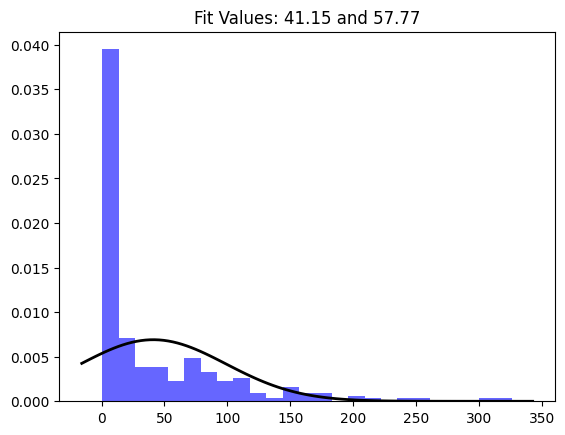

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = final_df['Subscription (times)'].tolist()
# Fit a normal distribution to
# the data:
# mean and standard deviation
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
plt.title(title)

plt.show()

Text(0.5, 0, 'Subcription (times)')

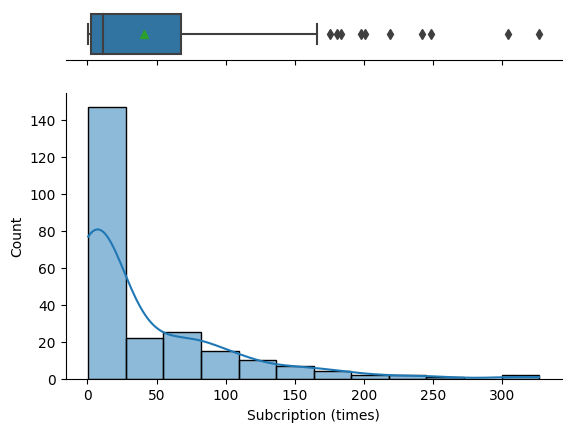

In [ ]:
import seaborn as sns
x = final_df['Subscription (times)'].tolist()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=x, ax=ax_box, showmeans=True)
sns.histplot(x=x, bins=12, kde=True, stat= "count", ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlabel('Subcription (times)')

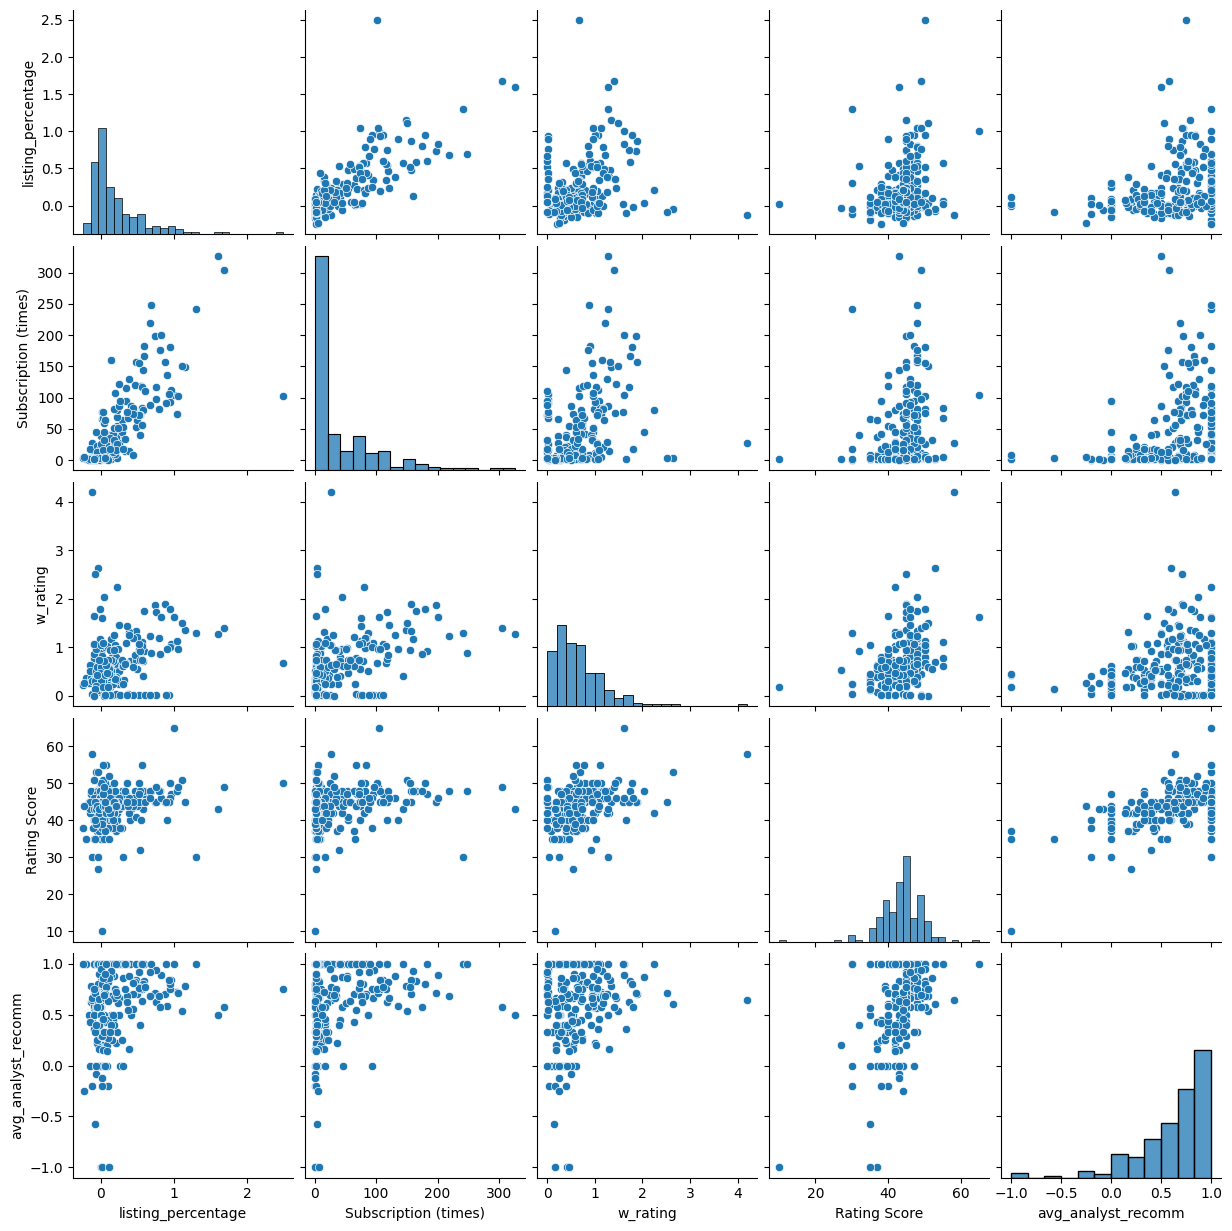

In [ ]:
sns.pairplot(final_df[['listing_percentage', 'Subscription (times)', 'w_rating',
                       'Rating Score', 'avg_analyst_recomm']])

<ipython-input-133-bb500b74402a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sb.heatmap(final_df.corr(), cmap="YlGnBu", annot=True, fmt=".2f")


<Axes: >

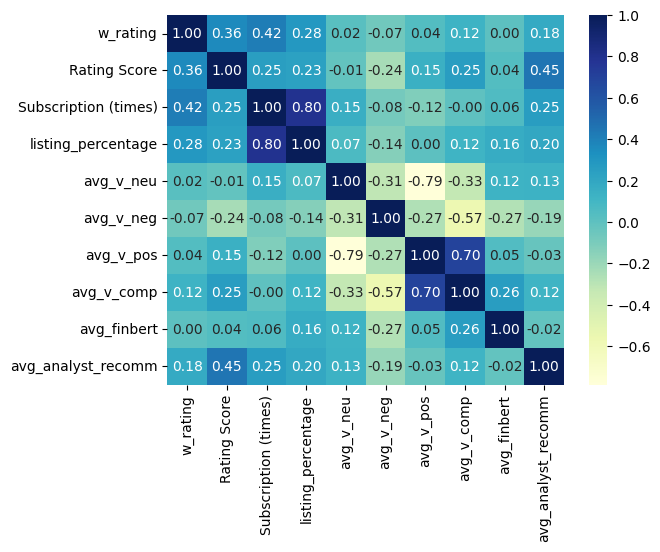

In [ ]:
# correlation
sb.heatmap(final_df.corr(), cmap="YlGnBu", annot=True, fmt=".2f")

In [ ]:
# simple linear regression

from sklearn import linear_model

X = final_df[['w_rating', 'Rating Score', 'Subscription (times)', 'avg_analyst_recomm',
              'avg_v_comp', 'avg_finbert']]
y = final_df['listing_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.18, random_state=1)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# variance score: 1 means perfect prediction
print('Number of test samples:', len(X_test))
print('\nVariance score on test data:', regr.score(X_test, y_test))
print('Variance score on train data:', regr.score(X_train, y_train))


# evaluation of the regression
data = regr.predict(X_test)
print(explained_variance_score(y_test, data))
# Mean Squared Error: 0 means the model is perfect.
print('\nMean Squared Error', mean_squared_error(y_test, data))
# The lower the RMSE, the better the model and its predictions
print('Root mean Squared Error', mean_squared_error(y_test, data, squared=False))
# The lower the MAE, the better the model and its predictions
print('Mean abs Error', mean_absolute_error(y_test, data))

Number of test samples: 43

Variance score on test data: 0.7294122257559966
Variance score on train data: 0.6471537555000417
0.7295023806043863

Mean Squared Error 0.03025011275850643
Root mean Squared Error 0.17392559546687322
Mean abs Error 0.132433764251989


In [ ]:
print(regr.coef_)
print(regr.intercept_)

[-0.05601034  0.00418467  0.00514041 -0.04967681  0.56253396  0.50437807]
-0.5903508839614088


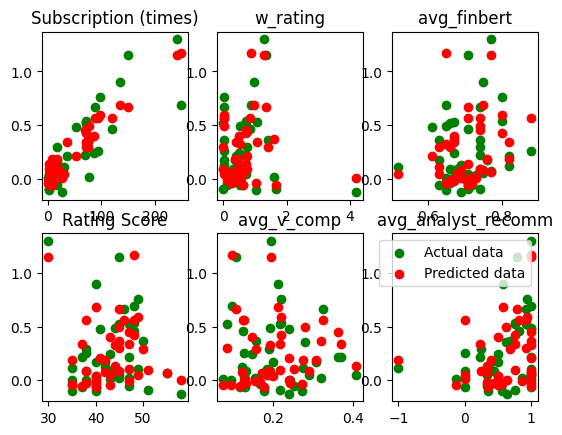

In [ ]:
figure, axis = plt.subplots(2, 3)

axis[0, 0].scatter(X_test['Subscription (times)'], y_test.values, color="green", label='Actual data')
axis[0, 0].scatter(X_test['Subscription (times)'], data, color="red", label='Predicted data')
axis[0, 0].set_title('Subscription (times)')

axis[1, 0].scatter(X_test['Rating Score'], y_test.values, color="green", label='Actual data')
axis[1, 0].scatter(X_test['Rating Score'], data, color="red", label='Predicted data')
axis[1, 0].set_title('Rating Score')

axis[1, 1].scatter(X_test['avg_v_comp'], y_test.values, color="green", label='Actual data')
axis[1, 1].scatter(X_test['avg_v_comp'], data, color="red", label='Predicted data')
axis[1, 1].set_title('avg_v_comp')

axis[0, 1].scatter(X_test['w_rating'], y_test.values, color="green", label='Actual data')
axis[0, 1].scatter(X_test['w_rating'], data, color="red", label='Predicted data')
axis[0, 1].set_title('w_rating')

axis[1, 2].scatter(X_test['avg_analyst_recomm'], y_test.values, color="green", label='Actual data')
axis[1, 2].scatter(X_test['avg_analyst_recomm'], data, color="red", label='Predicted data')
axis[1, 2].set_title('avg_analyst_recomm')

axis[0, 2].scatter(X_test['avg_finbert'], y_test.values, color="green", label='Actual data')
axis[0, 2].scatter(X_test['avg_finbert'], data, color="red", label='Predicted data')
axis[0, 2].set_title('avg_finbert')

plt.legend()

In [ ]:
# deep learning regression

# Separate Target Variable and Predictor Variables
TargetVariable=['listing_percentage']
Predictors=['w_rating', 'Rating Score', 'Subscription (times)', 'avg_v_comp', 'avg_finbert', 'avg_analyst_recomm']
#Predictors=['Subscription (times)']

X=final_df[Predictors].values
y=final_df[TargetVariable].values

# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# importing the libraries
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=512, input_dim=6, kernel_initializer='normal'))

# Defining the Second layer of the model
model.add(Dense(units=1024, kernel_initializer='normal', activation='relu'))

# Defining the third layer of the model
model.add(Dense(units=256, kernel_initializer='normal', activation='relu'))

# The output neuron is a single fully connected node
model.add(Dense(1, kernel_initializer='normal'))

# Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fitting the ANN to the Training set
model.fit(X_train, y_train ,batch_size = 32, epochs = 500, verbose=1)

Epoch 1/500
7/7 [==============================] - 2s 30ms/step - loss: 80.0865
Epoch 2/500
7/7 [==============================] - 0s 32ms/step - loss: 4.6518
Epoch 3/500
7/7 [==============================] - 0s 26ms/step - loss: 2.2718
Epoch 4/500
7/7 [==============================] - 0s 27ms/step - loss: 0.6858
Epoch 5/500
7/7 [==============================] - 0s 28ms/step - loss: 0.2120
Epoch 6/500
7/7 [==============================] - 0s 30ms/step - loss: 0.2138
Epoch 7/500
7/7 [==============================] - 0s 29ms/step - loss: 0.0931
Epoch 8/500
7/7 [==============================] - 0s 29ms/step - loss: 0.0632
Epoch 9/500
7/7 [==============================] - 0s 27ms/step - loss: 0.0646
Epoch 10/500
7/7 [==============================] - 0s 27ms/step - loss: 0.0528
Epoch 11/500
7/7 [==============================] - 0s 23ms/step - loss: 0.0539
Epoch 12/500
7/7 [==============================] - 0s 29ms/step - loss: 0.0540
Epoch 13/500
7/7 [==============================

In [ ]:
# Generating Predictions on testing data
Predictions=model.predict(X_test)

# Scaling the predicted Price data back to original price scale
#Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
#y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
#Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=X_test, columns=Predictors)
TestingData['listing_percentage']=y_test
TestingData['Predicted_percentage']=Predictions

# Computing the Variance
from sklearn.metrics import explained_variance_score
print("\nVariance score:", explained_variance_score(y_test, Predictions))

# Mean Squared Error: 0 means the model is perfect.
print('\nMean Squared Error', mean_squared_error(y_test, Predictions))
# The lower the RMSE, the better the model and its predictions
print('Root mean Squared Error', mean_squared_error(y_test, Predictions, squared=False))
# The lower the MAE, the better the model and its predictions
print('Mean abs Error', mean_absolute_error(y_test, Predictions))

print(len(TestingData.index))
TestingData.head()

1/1 [==============================] - 0s 46ms/step

Variance score: 0.576415466689659

Mean Squared Error 0.030125122327677587
Root mean Squared Error 0.17356590197293242
Mean abs Error 0.10861237324419422
24


,w_rating,Rating Score,Subscription (times),avg_v_comp,avg_finbert,avg_analyst_recomm,listing_percentage,Predicted_percentage
0,1.135763,48.0,73.30,0.213712,0.770000,0.722222,1.048571,0.496620
1,0.616785,46.0,43.84,0.270617,0.690000,1.000000,0.211864,0.224163
2,0.454821,35.0,7.67,0.275087,0.820000,-1.000000,0.117647,0.091170
3,0.394808,38.0,2.17,0.168033,0.750000,-0.200000,0.016636,-0.006569
4,0.032054,30.0,0.76,0.050692,0.641509,-0.200000,-0.115746,-0.025864


Text(0, 0.5, 'listing_percentage')

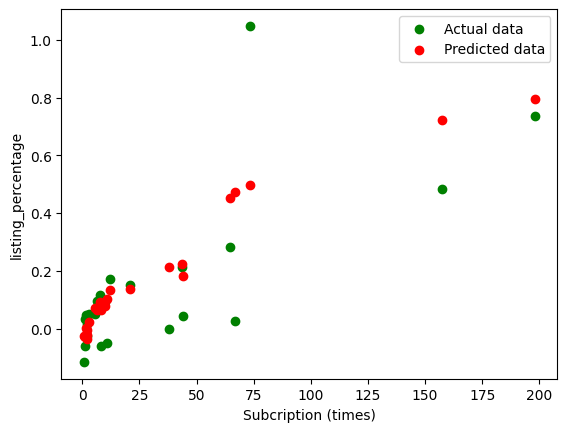

In [ ]:
x_axis = [i[-4] for i in X_test]

plt.scatter(x_axis, y_test, color="green", label='Actual data')
plt.scatter(x_axis, Predictions, color="red", label='Predicted data')
plt.legend()
plt.xlabel('Subcription (times)')
plt.ylabel('listing_percentage')

In [ ]:
# Generating Predictions on testing data
Predictions=model.predict(X_train)

# Scaling the predicted Price data back to original price scale
#Predictions=TargetVarScalerFit.inverse_transform(Predictions)

# Scaling the y_test Price data back to original price scale
#y_test_orig=TargetVarScalerFit.inverse_transform(y_test)

# Scaling the test data back to original scale
#Test_Data=PredictorScalerFit.inverse_transform(X_test)

TestingData=pd.DataFrame(data=X_train, columns=Predictors)
TestingData['listing_percentage']=y_train
TestingData['Predicted_percentage']=Predictions

# Computing the Variance
from sklearn.metrics import explained_variance_score
print("\nVariance score:", explained_variance_score(y_train, Predictions))

print(len(TestingData.index))
TestingData.head()

7/7 [==============================] - 0s 4ms/step

Variance score: 0.7105159182678227
213


,w_rating,Rating Score,Subscription (times),avg_v_comp,avg_finbert,avg_analyst_recomm,listing_percentage,Predicted_percentage
0,0.234054,45.0,27.00,0.188098,0.75,1.000000,0.242778,0.178876
1,0.012899,44.0,24.87,0.266324,0.74,0.692308,0.214642,0.196150
2,0.742599,38.0,18.03,0.188878,0.74,0.250000,0.293506,0.102021
3,0.725234,45.0,2.06,0.250284,0.75,0.888889,0.140000,-0.015130
4,0.637214,43.0,19.96,0.225698,0.63,1.000000,0.030405,0.104514


Text(0, 0.5, 'listing_percentage')

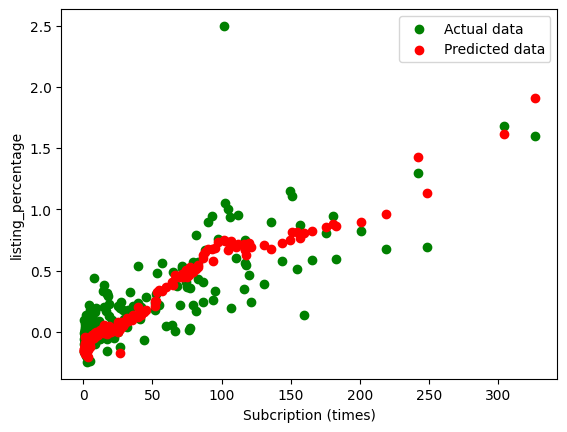

In [ ]:
x_axis = [i[-3] for i in X_train]

plt.scatter(x_axis, y_train, color="green", label='Actual data')
plt.scatter(x_axis, Predictions, color="red", label='Predicted data')
plt.legend()
plt.xlabel('Subcription (times)')
plt.ylabel('listing_percentage')

In [ ]:
pip install vaderSentiment

In [ ]:
from finvader import finvader

text = "Its a buy, amazing fundamentals"

score_neu = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'neu')
score_pos = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'pos')
score_neg = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'neg')
score_com = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'compound')

print(text)
print('Neu:',score_neu, 'Pos:', score_pos, 'Neg:', score_neg, 'Comp:', score_com)

Its a buy, amazing fundamentals
Neu: 0.487 Pos: 0.513 Neg: 0.0 Comp: 0.0284


In [ ]:
pip install finvader

In [ ]:
from finvader import finvader

text = "I will not apply for this IPO; expensive valuation"

score_neu = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'neu')
score_pos = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'pos')
score_neg = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'neg')
score_com = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'compound')

print(text)
print('Neu:',score_neu, 'Pos:', score_pos, 'Neg:', score_neg, 'Comp:', score_com)

I will not apply for this IPO; expensive valuation
Neu: 0.871 Pos: 0.0 Neg: 0.129 Comp: -0.009


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from finvader import finvader

text = "can some one suggest on this IPO?"

score_neu = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'neu')
score_pos = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'pos')
score_neg = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'neg')
score_com = finvader(text,
                  use_sentibignomics = True,
                  use_henry = True,
                  indicator = 'compound')

print(text)
print('Neu:',score_neu, 'Pos:', score_pos, 'Neg:', score_neg, 'Comp:', score_com)

can some one suggest on this IPO?
Neu: 0.856 Pos: 0.144 Neg: 0.0 Comp: 0.0026


In [ ]:
# checking the trained model on live data
from transformers import BertTokenizer, TFBertForSequenceClassification

path = 'drive/MyDrive/nlp_data'
# Load tokenizer
bert_tokenizer = BertTokenizer.from_pretrained(path +'/Tokenizer1')

# Load model
bert_model = TFBertForSequenceClassification.from_pretrained(path +'/Model1')

def Get_sentiment(Review, Tokenizer=bert_tokenizer, Model=bert_model):
    # Convert Review to a list if it's not already a list
    if not isinstance(Review, list):
        Review = [Review]

    Input_ids, Token_type_ids, Attention_mask = Tokenizer.batch_encode_plus(Review,
                                                                             padding=True,
                                                                             truncation=True,
                                                                             max_length=128,
                                                                             return_tensors='tf').values()
    prediction = Model.predict([Input_ids, Token_type_ids, Attention_mask])

    label = {
    2: 'Neutral',
    1: 'Neutral',
    0: 'Neutral'
    }

    # Use argmax along the appropriate axis to get the predicted labels
    pred_labels = tf.argmax(prediction.logits, axis=1)

    # Convert the TensorFlow tensor to a NumPy array and then to a list to get the predicted sentiment labels
    pred_labels = [label[i] for i in pred_labels.numpy().tolist()]

    return pred_labels


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at drive/MyDrive/nlp_data/Model1 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentence = "It's a buy, amazing fundamentals."
Get_sentiment(sentence)

1/1 [==============================] - 5s 5s/step


['Positive']

In [ ]:
sentence = "I will not apply for this IPO; expensive valuation"
Get_sentiment(sentence)

1/1 [==============================] - 6s 6s/step


['Negative']

In [ ]:
text = "can some one suggest on this IPO?"
Get_sentiment(text)

1/1 [==============================] - 6s 6s/step


['Neutral']

Text(0.5, 0, 'listing percentage')

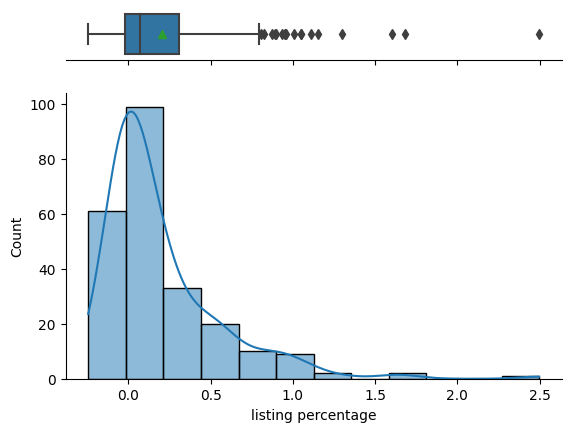

In [8]:
import seaborn as sns
x = final_df['listing_percentage'].tolist()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=x, ax=ax_box, showmeans=True)
sns.histplot(x=x, bins=12, kde=True, stat= "count", ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
plt.xlabel('listing percentage')

In [ ]:
1) summarization nltk
2) experiment with google translate
3) combining all the dataframes - done
4) finding individual regressions - done
5) deep learning multi variable regression method - done

# finbert and pyfin 6 new columns
# 237*100
# average compound vader
# finbert sentiment - avg
# pyfin sentiment - avg
# normalised compound vader - (no of comments)


# adlabs - 5 comments - (add sentiments/5)*(x-xmin/xmax-xmin)